# Zastosowania DFT
Laboratorium 9 - Metody Obliczeniowe w Nauce i Technice

In [1]:
import os
import cmath
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import peak_local_max
from PIL import Image, ImageFont, ImageDraw

In [38]:
def load_image(img_path: str, **kwargs) -> np.ndarray:
    invert: bool = kwargs.get("invert", False)
    to_grey_scale: bool = kwargs.get("gscale", False)

    image = imread(img_path)
    if invert:
        image = np.invert(image)
    if to_grey_scale:
        image = rgb2gray(image)

    return image

In [3]:
def show_image(
    img,
    figsize: tuple[float, float] = (8, 8),
    dpi: int = 120,
    cmap = "gray"
) -> None:
    fig, ax = plt.subplots()
    fig.figsize = figsize
    fig.dpi = dpi
    ax.set_axis_off()
    plt.imshow(img, cmap=cmap)

## Zadanie 1. Analiza obrazów.
- Wczytaj obraz przedstawiający tekst, dokonaj odwrócenia kolorów (czarne tło), a następnie jego transformacji do domeny częstotliwościowej za pomocą DFT. Przedstaw wartości fazy i modułu współczynników Fouriera (osobno).
- Wybierz  przykładowego  reprezentanta  grupy  -  wytnij  z  dużego  zdjęcia  wzorzec obiektu np. literę _e_ lub charakterystyczny fragment ryby z ławicy (`imcrop`).
- Wykorzystując transformację Fouriera oblicz korelację między wybranym wzorcem, a całym obrazem<sup>1</sup>.
- Przedstaw otrzymany obraz wyjściowy oraz punkty, w których wykryto wystąpienie wzorca (nałóż je na obraz oryginalny).
- Znajdź liczbę wystąpień wzorca. Testy przeprowadź na dwóch zbiorach danych.

<sup>1</sup>`C = real( ifft2(fft2(galia) .* fft2(rot90(imp, 2), h, w)) );`

### Wczytanie obrazu i odwrócenie jego kolorów
Na początku wczytuję obraz i odwracam paletę kolorów, aby tło tekstu było czarne, a tekst biały.

#### Tekst

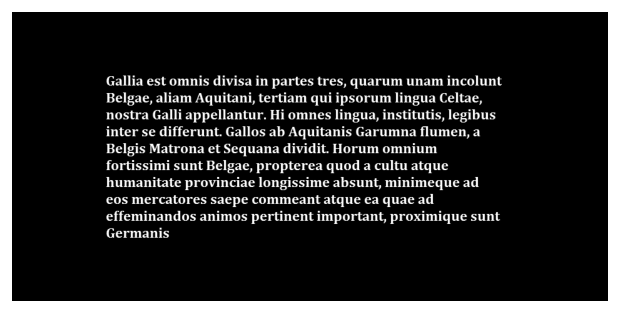

In [4]:
gs_text_image = load_image("./assets/ex1/galia.png", invert=True, gscale=True)
H, W = gs_text_image.shape
show_image(gs_text_image, figsize=(10, 8))

#### Pojedyncza litera (_e_)

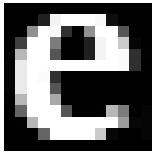

In [5]:
gs_letter = load_image("./assets/ex1/galia-e.png", invert=True, gscale=True)
show_image(gs_letter, figsize=(3, 2), dpi=40)

### Szybka transformacja Fouriera tekstu
Po przekształceniu tekstu i litery dokonuję transformacji obrazu, korzystając z FFT z biblioteki `NumPy` (`np.fft`).

In [6]:
# inverted_text_image_fft = np.fft.fftshift(np.fft.fft2(inverted_text_image))
# plt.figure(num=None, figsize=(8, 6), dpi=80)
# plt.imshow(np.log(abs(inverted_text_image_fft)), cmap='gray')

image_fft = np.fft.fft2(gs_text_image)

#### Wizualizacja wyników

##### Wykres argumentów wartości transformacji

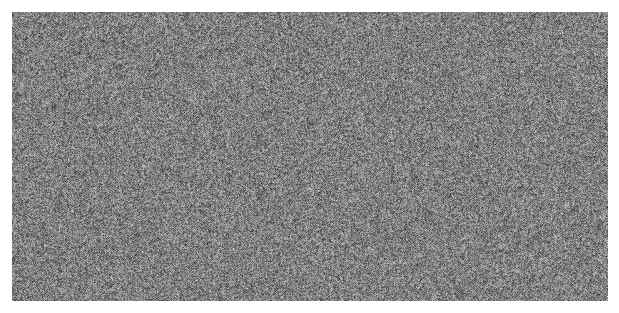

In [7]:
phase_image_fft = np.array([[cmath.phase(c) for c in row] for row in image_fft])
show_image(phase_image_fft)

##### Wykres modułów wartości transformacji
Wynik transformacji został zlogarytmowany, ponieważ wartości były zbyt duże i zbliżone do siebie.

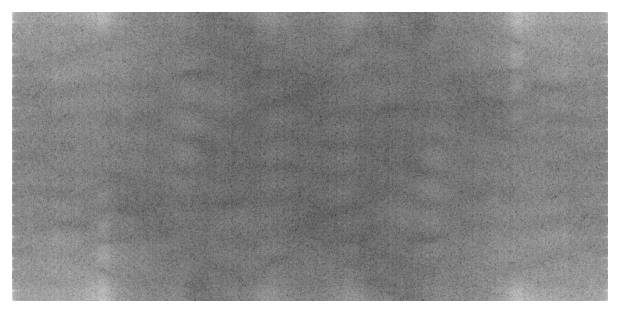

In [8]:
abs_image_fft = np.array([[abs(c) for c in row] for row in image_fft])
show_image(np.log(abs_image_fft))

#### Obliczenie korelacji wzorca z bazowym obrazem

In [9]:
def correlation(base_image, pattern) -> np.ndarray:
    H, W = base_image.shape
    return np.real(np.fft.ifft2(np.fft.fft2(base_image) * np.fft.fft2(np.rot90(pattern, 2), (H, W))))


C = correlation(gs_text_image, gs_letter)

##### Wyświetlenie korelacji

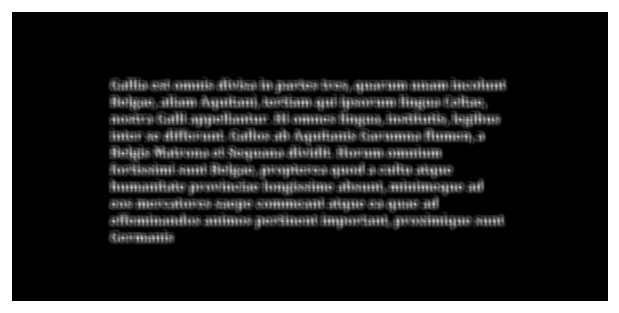

In [10]:
show_image(C)

##### Wyświetlenie punktów, gdzie istnieją elementy bardzo podobne

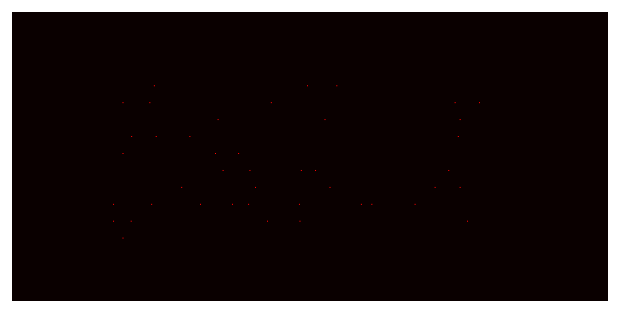

In [11]:
C_filtered = np.where(C > 50, C, 0)
show_image(C_filtered, cmap="hot")

##### Wyświetlenie znalezionych punktów na tle bazowej grafiki

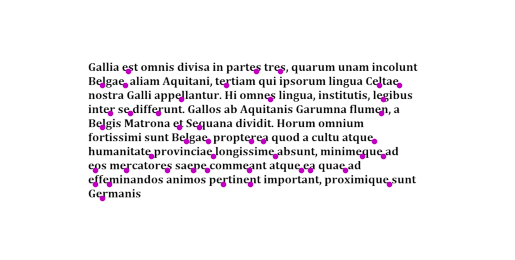

In [12]:
fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(gs_text_image, cmap="Greys")

coordinates = peak_local_max(C, min_distance=12, threshold_rel=.95)
ax.plot(coordinates[:, 1], coordinates[:, 0], 'm.')

plt.show()

#### Liczba wystąpień wzorców

In [13]:
# Text (Gallia)
C0 = correlation(gs_text_image, gs_letter)
C0_filtered = np.where(C0 > 50, C0, 0)
coordinates0 = peak_local_max(C0, min_distance=12, threshold_rel=.95)

# Shoal of fish
gs_shoal_image = load_image("./assets/ex1/fish-shoal.jpg", gscale=True)
gs_fish_image = load_image("./assets/ex1/fish.png", gscale=True)
C1 = correlation(gs_shoal_image, gs_fish_image)
C1_filtered = np.where(C1 > 163, C1, 0)
coordinates1 = peak_local_max(C1, min_distance=6, threshold_rel=.8)

print("Liczba wystąpień litery 'e' w tekscie:\t\t\t\t", coordinates0.shape[0])
print("Liczba podobnych ryb (do wzorca) w znajdujących się w ławicy:\t", coordinates1.shape[0])

Liczba wystąpień litery 'e' w tekscie:				 43
Liczba podobnych ryb (do wzorca) w znajdujących się w ławicy:	 13


Dla ławicy ryb można spróbować pozmieniać parametry `threshold_rel`, `min_distance` i warunek w funkcji `np.where()` (głównie `threshold_rel`), aby zwiększyć lub zmniejszyć dokładność, np.:

In [14]:
coordinates1 = peak_local_max(C1, min_distance=6, threshold_rel=.4)
print("Liczba podobnych ryb (do wzorca) w znajdujących się w ławicy:\t", coordinates1.shape[0])

Liczba podobnych ryb (do wzorca) w znajdujących się w ławicy:	 282


## Zadanie 2.

In [21]:
FONT_PATH: str = "./assets/ex2/fonts/"
FONT_NAMES: list[str] = [
    "verdana.ttf",
    "tahomabd.ttf",
    "RobotoSlab-Regular.ttf"
]
FONT_CHARACTERS_PATH: str = "./assets/ex2/images/fonts/"


def load_font(path: str, size=16) -> ImageFont.FreeTypeFont:
    image_font: ImageFont.FreeTypeFont = ImageFont.truetype(path, size)
    return image_font


def render_text(text: str, font: ImageFont.FreeTypeFont, name: str, size: tuple[int, int] = (192, 192)) -> None:
    # Render text
    left, top, _, _ = font.getbbox(text)
    pos = (-(left - 1), -(top - 1))
    image = Image.new("RGB", size)
    draw = ImageDraw.Draw(image)
    draw.text(pos, text, "white", font=font)

    # Evaluate real bounding box
    left, top, right, bottom = np.inf, np.inf, 0, 0
    for i, pixel in enumerate(image.getdata()):
        if np.any(np.array(pixel) > 0):
            x, y = i % size[0], i // size[1]
            left, top = min(left, x), min(top, y)
            right, bottom = max(right, x), max(bottom, y)

    # Crop image
    image = image.crop((
        max(left - 1, 0),
        max(top - 1, 0),
        min(right + 2, size[0] - 1),
        min(bottom + 2, size[1] - 1)
    ))
    
    # Save text as PNG file
    font_name: str = f"{font.getname()[0]} {font.getname()[1]}".lower().replace(' ', '-')
    path: str = os.path.join(FONT_CHARACTERS_PATH, font_name, f"{name}.png")
    # print(path)
    image.save(path)
    image.close()


def render_character(char: str, font: ImageFont, size: tuple[int, int] = (192, 192)) -> None:
    if len(char) != 1:
        raise ValueError("Char is not a character (size different than 1)") 
    
    render_text(char, font, ord(char), size)


def create_characters(size=16) -> None:
    for font_name in FONT_NAMES:
        font: ImageFont.FreeTypeFont = load_font(os.path.join(FONT_PATH, font_name), size)
        for c in (chr(i) for i in range(33, 127)):
            render_character(c, font, (2 * size, 2 * size))


In [27]:
create_characters(16)

(13, 119) (186, 746)
(-173, 627)
-15.4250895028989


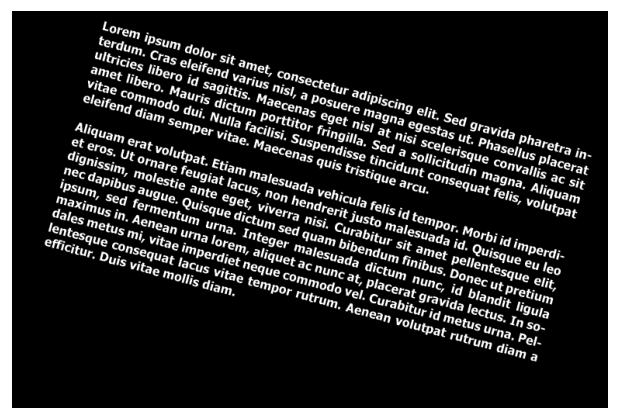

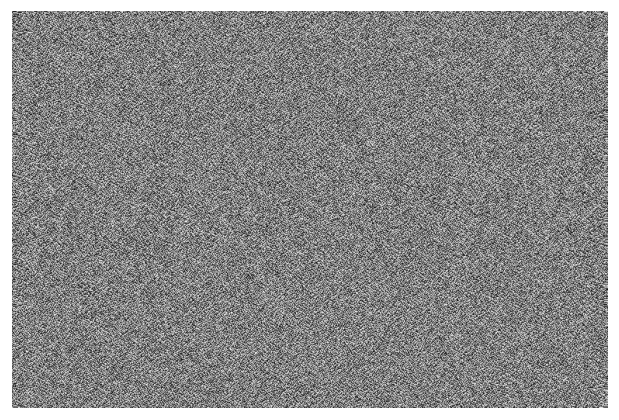

In [77]:
# def fill_text_image(image):
#     H, W = image.shape

#     left, top, right, bottom = np.inf, np.inf, 0, 0
#     for i, j in [(i, j) for i in range(H) for j in range(W)]:
#         if image[i, j] > 10**-6:
#             left, top = min(left, j), min(top, i)
#             right, bottom = max(right, j), max(bottom, i)

#     for i, j in [(i, j) for i in range(H) for j in range(W)]:
#         if left <= j <= right and top <= i <= bottom:
#             image[i, j] = 1

#     return image


def get_text_rotation(image, deg: bool = False) -> float:
    H, W = image.shape
    
    # (i, j)
    upper_left      = (np.inf, 0)
    upper_right     = (0, 0)

    for i, j in [(i, j) for i in range(H) for j in range(W)]:
        if image[i, j] > 10**-6:
            if upper_left[0] > i:
                upper_left = (i, j)
            elif upper_right[1] < j:
                upper_right = (i, j)
    
    p = ((H - upper_right[0]) - (H - upper_left[0]), upper_right[1] - upper_left[1])
    angle_rad = np.arctan2(p[0], p[1])

    return angle_rad
   

image_text0 = load_image("./assets/ex2/images/texts/lorem-tahoma-bold-15deg.png", invert=True, gscale=True)
image_text1 = load_image("./assets/ex2/images/texts/lorem-tahoma-bold.png", invert=True, gscale=True)
get_text_rotation(image_text0)
show_image(image_text0)
image_text1_phase = np.array([[cmath.phase(c) for c in row] for row in np.fft.fft2(image_text1)])
show_image(image_text1_phase)
# o_letter = load_image("./assets/ex2/images/fonts/verdana-regular/111.png", gscale=True)
# C = correlation(image_text, o_letter)
# show_image(image_text, (10, 8))
# show_image(C, (10, 8))

21.261145713187233


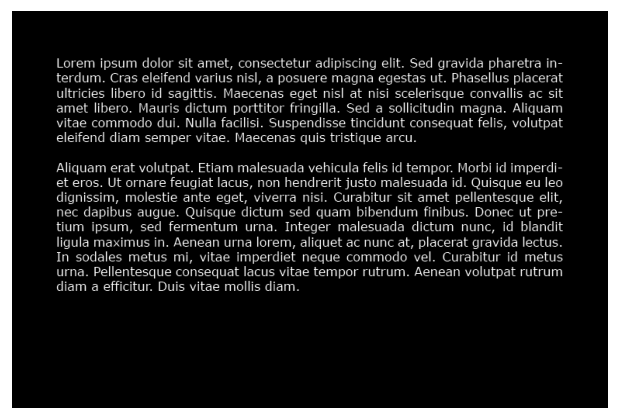

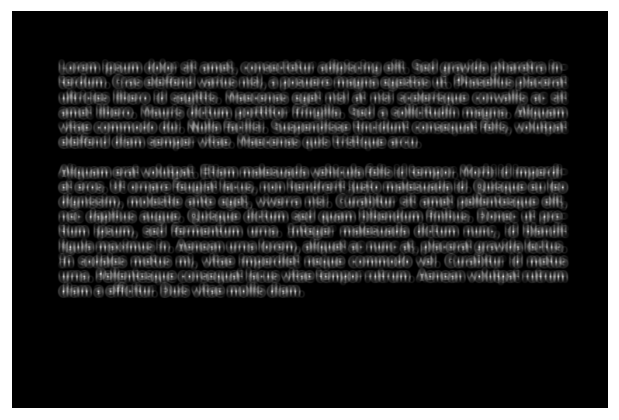

In [44]:
image_text = load_image("./assets/ex2/images/texts/lorem-verdana.png", invert=True, gscale=True)
o_letter = load_image("./assets/ex2/images/fonts/verdana-regular/111.png", gscale=True)
C = correlation(image_text, o_letter)
show_image(image_text, (10, 8))
show_image(C, (10, 8))
print(C.max())